Importing the libraries and the data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap


/tmp/ipykernel_81174/1258853450.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Reading the files and coverting them in a format that will be useful later.
customer = pd.read_csv('CustomerId.csv').merge(pd.read_csv('CustomerNorthing.csv'), how='inner').merge(pd.read_csv('CustomerEasting.csv'), how='inner')
X = customer[['CustomerNorthing', 'CustomerEasting']].values  
demand_per_product_period_scenario = pd.read_csv("DemandPeriodScenarios.csv")

Running KMeans to cluster customers

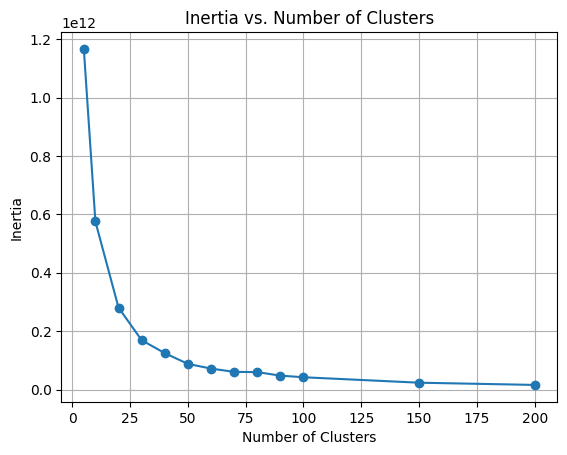

In [3]:
#Determining the value of clusters to use
# Parameters for KMeans
init_method = 'random'
n_init = 1  
random_state = 2  # Fixed random seed
n_clusters_list = [5, 10, 20,30, 40, 50, 60, 70, 80, 90, 100, 150, 200]

inertia_values = []

for n_clusters in n_clusters_list:
    # Create KMeans instance
    kmeans = KMeans(n_clusters=n_clusters, init=init_method, n_init=n_init, random_state=random_state)

    # Fit the KMeans algorithm
    kmeans.fit(X)
    
    inertia = kmeans.inertia_
    inertia_values.append(inertia)

    # Get cluster assignments and plot the results
    labels = kmeans.labels_

# Plotting the values
plt.plot(n_clusters_list, inertia_values, marker='o')  # Plotting inertia values against number of clusters
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig('inertia_vs_number_of_clusters.png')  # You can change the filename and extension as needed

plt.show()

In [4]:
# Changing the value of clusters to 40 and running the same code to plot the map.
n_clusters = 40


# Create KMeans instance
kmeans = KMeans(n_clusters=n_clusters, init=init_method, n_init=n_init, random_state=random_state)
kmeans.fit(X)
labels = kmeans.labels_

# To prevent duplicate code, the results are printed once closest neighbours are found below.

Find the customer that is the closest to the centroid using Euclidean distance

In [5]:
# Initiating lists
closest_points = []
closest_points_index = []

# This loop checks within each cluster and finds the index of the customer closest to centroid using Euclidean distance
# Coordinates are found to make plotting easier
for cluster_idx in range(n_clusters):
    cluster_points = X[labels == cluster_idx]  # Select points belonging to current cluster
    centroid = kmeans.cluster_centers_[cluster_idx]  # Get centroid of current cluster
    
    # Calculate distances between points in cluster and centroid
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    
    # Find index of point closest to centroid
    closest_point_idx = np.argmin(distances)
    
    # Get coordinates of closest point
    closest_point_coords = cluster_points[closest_point_idx]
    closest_points_index.append(closest_point_idx)
    
    # Append index and coordinates of closest point to list
    closest_points.append(closest_point_coords)

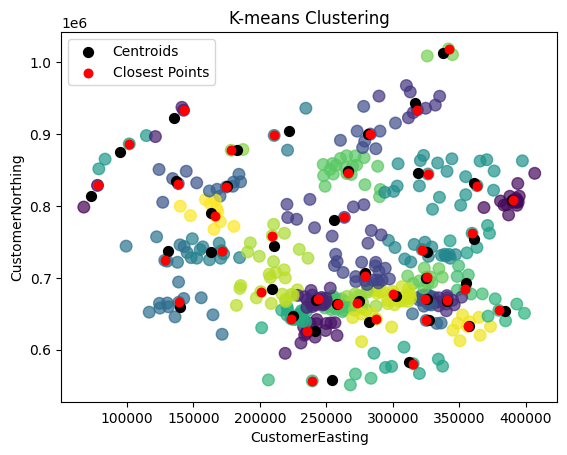

In [6]:
# New plot where both centroids and the closest neighbours can be seen.
plt.scatter(X[:, 1], X[:, 0], c=labels, s=70, alpha=0.7)  # Changed the order of coordinates for scatter plot
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], c='black', marker='.', s=200, label='Centroids')  # Changed the order of coordinates for centroids

# Plot the closest points
closest_points = np.array(closest_points)
plt.scatter(closest_points[:, 1], closest_points[:, 0], c='red', marker='.', s=150, label='Closest Points')  # Changed the order of coordinates for centroids

# Organise the labels, legend and save the plot
plt.title('K-means Clustering')
plt.xlabel('CustomerEasting')
plt.ylabel('CustomerNorthing')
plt.legend()
plt.savefig('K-means_clustering.png')  # You can change the filename and extension as needed
plt.show()

Next, we find where in the initial dataset (with all customers) are our values for the closest neighbours.

In [7]:
closest_points_within_X = []

for cluster_idx, closest_point_idx in enumerate(closest_points_index):
    # Get the label of the cluster corresponding to the closest point
    cluster_label = cluster_idx
    
    # Filter out the points belonging to this cluster
    cluster_points_within_X = X[labels == cluster_label]
    
    # Get the index of the closest point within X and append
    closest_point_within_X_idx = np.where((X[:, 0] == cluster_points_within_X[closest_point_idx][0]) & (X[:, 1] == cluster_points_within_X[closest_point_idx][1]))[0][0]
    closest_points_within_X.append(closest_point_within_X_idx)

#closest points with X will be relevant towards the end of this code when we are creating sums for each cluster

Finding the sum of demands for each cluster, product, period and scenario

In [8]:
# We want to group all indices from the initial dataset to separate lists so that we can find the sum of demands
cluster_arrays = [np.where(labels == cluster_label)[0].tolist() for cluster_label in range(n_clusters)]

# Create an empty DataFrame to store the sums of demands for each cluster
cluster_sums = pd.DataFrame(columns=["Cluster", "Products", "Period", "Scenario"])

In [9]:
# Iterate over each cluster
for i, cluster in enumerate(cluster_arrays):
    # Filter demand DataFrame for customer IDs in the current cluster
    cluster_demand = demand_per_product_period_scenario[demand_per_product_period_scenario["Customers"].isin(cluster)]

    # Group by Products, Period, and Scenario and calculate the sum of demands
    sums = cluster_demand.groupby(["Products", "Periods", "Scenarios"])["DemandPeriodScenarios"].sum().reset_index()

    # Add a column for the cluster number
    sums["Cluster"] = i

    # Append the sums to cluster_sums DataFrame
    cluster_sums = pd.concat([cluster_sums, sums], ignore_index=True)

# Drop empty columns
cluster_sums_filtered = cluster_sums.dropna(axis=1, how='all')
cluster_sums_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Cluster                160000 non-null  object 
 1   Products               160000 non-null  object 
 2   Periods                160000 non-null  float64
 3   Scenarios              160000 non-null  float64
 4   DemandPeriodScenarios  160000 non-null  float64
dtypes: float64(3), object(2)
memory usage: 6.1+ MB


In [10]:
# Create a dictionary mapping cluster numbers to values
value_map = {i: value for i, value in enumerate(closest_points_within_X)}

# Add a new column based on the "Cluster" column
cluster_sums_filtered['Closest_Index'] = cluster_sums_filtered['Cluster'].map(value_map)

# Output filtered DataFrame cluster_sums_filtered to a CSV file
cluster_sums_filtered.to_csv("cluster_sums.csv", index=False)

/tmp/ipykernel_81174/3845555050.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_sums_filtered['Closest_Index'] = cluster_sums_filtered['Cluster'].map(value_map)
